In [1]:
import numpy as np
import scipy as sp
import random as rand
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True)

## Differential Evolution

In [2]:
# Benchmark function, Rosenbrock, global minima at x = 1
def rosen(x):
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

In [16]:
def sphere(x):
    return sum(x**2)

In [50]:
def rastrigin(x):
    return sum(10+x**2-10*np.cos(2*np.pi*x))

In [76]:
def initialize(n, bounds):
    # generates a np array of n rows of random values that lies within the range given by bounds array
    # bounds array is a list of tuples, each tuple indicate the (min value, max_value) for given dimension
    # length of bounds is assumed to define the number of dimensions required
    bounds_range = np.apply_along_axis(lambda x:x[1]-x[0], 1, np.array(bounds))
    bounds_min = np.apply_along_axis(lambda x:x[0], 1, np.array(bounds))
    p_set = np.random.rand(1, len(bounds))
    p_set = p_set*bounds_range+bounds_min
    
    for i in range(n-1):
        p = np.random.rand(1, len(bounds))*bounds_range+bounds_min
        p_set = np.vstack([p_set, p])
        
    return p_set

def select_vectors(p_set, r, exclude_i):
    # chooses r vectors from the p_set, excluding the one at index: exclude_i 
    n = len(p_set)
    if r >= n:
        return
    return_set = np.empty(shape=(r,len(p_set[0])))
    
    exclude = set()
    exclude.add(exclude_i)
    
    i = 0
    while True:
        candidate = rand.randint(0, n-1)
        if candidate not in exclude:
            return_set[i] = p_set[candidate]
            exclude.add(candidate)
            i += 1
        if i >= r:
            break
    return return_set

def get_trial_vector(vectors, c):
    # calculate trial vector using the 3 vector provided
    if len(vectors) != 3:
        return
    return vectors[0] + c*(vectors[1] - vectors[2])

def crossover(parent, trial_vector, pcr):
    # if pcr = 1, means all choose from trial vector, if 0, means all choose from parent vector
    choose_trial = np.random.rand(1,len(trial_vector)) <= pcr
    return (choose_trial*trial_vector + (1-choose_trial)*parent)[0]

def bound_check(vector, bounds):
    # takes in 1d vector and check all values are within bounds provided, if not force to boundary value
    for i in range(len(vector)):
        if vector[i] < bounds[i][0]:
            vector[i] = bounds[i][0]
        elif vector[i] > bounds[i][1]:
            vector[i] = bounds[i][1]
    return vector
    
def differential_evolution(f, bounds, n=15, max_iter=1000):
    # finds minimal for function f subject to boundary given by bounds. n random starting positions
    
    # hyperparamters
    # c is the weight to multiply for the vector differential
    # pcr is the rate of crossover
    c = 0.9
    pcr = 0.9
    
    # initialize n random starting positions
    d = len(bounds) # dimension of inputs
    p_set = initialize(n, bounds)
    
    terminate = False
    itr = 0
    i_no_improvement = 0
    cur_sol = []
    best_fitness = f(p_set[0])
    
    while not terminate:
        fitness = np.apply_along_axis(f, 1, p_set)
        best_fitness = np.mean(fitness)
        
        for i in range(n):
            # select 3 other vectors from the positions
            # compute trial vector
            trial_vector = get_trial_vector(select_vectors(p_set, 3, i), c)
            
            # crossover
            offspring = crossover(p_set[i], trial_vector, pcr)
            offspring = bound_check(offspring, bounds)
            
            # select fitter between offspring and parent
            # minimization problem
            if f(offspring) < f(p_set[i]):
                p_set[i] = offspring
            if f(offspring) < best_fitness:
                best_fitness = f(offspring)
                p_set[np.argsort(fitness)[0]] = offspring
        
        new_fitness = np.apply_along_axis(f, 1, p_set)

        # store new solution
        cur_sol.append(p_set[np.argsort(new_fitness)[0]])
        
        if np.min(new_fitness) < best_fitness:
            best_fitness = np.min(new_fitness)
            best_sol = cur_sol[-1]
        
        # check for termination criteria
        if np.mean(new_fitness) >= np.mean(fitness):
            i_no_improvement += 1
        else:
            i_no_improvement = 0
        
        if itr > max_iter:
            terminate = True
        elif i_no_improvement > 20:
            terminate = True
        itr +=1
    
    print('the best solution is {} and function value is {}'.format(best_sol, best_fitness))
    return cur_sol

In [75]:
bounds = [(-100,100),(-100,100),(-100,100),(-100,100),(-100,100)]
differential_evolution(rosen, bounds, n=100, max_iter=100)

the best solution is [ 1.202663    0.28463307 -0.61330215  1.59611771  5.88472095] and function value is 1449.1663414425075


[array([ 1.32696739,  0.34871505,  3.72926572,  2.1374817 , 10.96607218]),
 array([ 1.32696739,  0.34871505,  3.72926572,  2.1374817 , 10.96607218]),
 array([-1.22402797, -0.74874431,  2.65196704, -1.03906978,  5.53517799]),
 array([ 0.01256842, -2.43430601, -1.79854805, -1.11236337, -0.74929855]),
 array([ 0.60297558,  1.17253573,  3.54792205, -0.0135726 ,  4.86497536]),
 array([ 0.01256842, -2.43430601, -1.79854805, -1.11236337, -0.74929855]),
 array([ 0.60297558,  1.17253573,  3.54792205, -0.0135726 ,  4.86497536]),
 array([ 0.60297558,  1.17253573,  3.54792205, -0.0135726 ,  4.86497536]),
 array([ 2.24561216,  3.07017499,  1.42380375,  8.59816897, 76.0627832 ]),
 array([ 2.24561216,  3.07017499,  1.42380375,  8.59816897, 76.0627832 ]),
 array([-2.47298196, -2.84703809,  3.09949198,  5.60564196, 38.7964426 ]),
 array([-2.47298196, -2.84703809,  3.09949198,  5.60564196, 38.7964426 ]),
 array([ 2.16795337, -2.54812855,  1.81734494,  1.582274  , -0.86941725]),
 array([ 2.16795337, -2.5

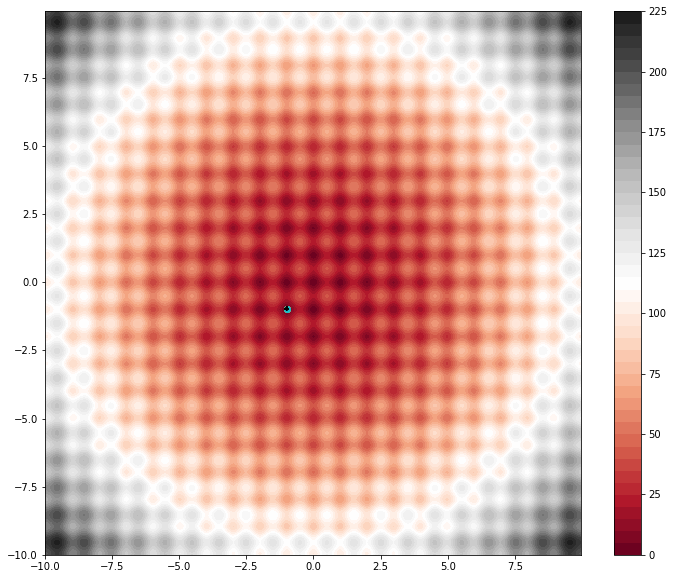

In [70]:
X = np.arange(-10,10,0.05)
Y = np.arange(-10,10,0.05)
X, Y = np.meshgrid(X, Y)
Z = np.empty(shape=(len(X),len(X)))
for i in range(len(X)):
    for j in range(len(X)):
        Z[i][j] = rastrigin(np.array([X[i][j], Y[i][j]]))
        
from matplotlib import cm
plt.figure(figsize=(12,10))
surf = plt.contourf(X, Y, Z, 50, cmap='RdGy')
plt.colorbar()

bounds = [(-20,20),(-20,20)]
movements = differential_evolution(rastrigin,bounds, n=10, max_iter = 100)
plt.scatter(movements[0][0],movements[0][1])
for i in range(1, len(movements)):
    plt.scatter(movements[i][0],movements[i][1])
    plt.arrow(movements[i-1][0], movements[i-1][1],
              (movements[i][0]-movements[i-1][0]),(movements[i][1]-movements[i-1][1]),
             head_width = 0.05)

In [67]:
movements

[array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([0.9544905 , 0.10154492]),
 array([0.94830969, 0.16199801]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.01643193, 0.1412127 ]),
 array([1.0164

In [60]:
from scipy.optimize import rosen, differential_evolution
bounds = [(-10,10), (-10,10), (-10,10), (-10,10), (-10,10)]
result = differential_evolution(rosen, bounds)
result.x, result.fun

(array([1., 1., 1., 1., 1.]), 3.1869980570928877e-28)

## Genetic Algorithm

In [ ]:
def selection(fitness, n:'number of pair of parents required'):
    # calculate probability of each p being selected as a parent
    f_inv = 1/(fitness/fitness.sum())
    prob = f_inv/f_inv.sum()
    # selecting n set of parents
    indexes = np.argsort(prob)[::-1]
    prob = np.sort(prob)[::-1]
    parents = []
    position = len(fitness)
    for i in range(n):
        parent = []
        for i in range(2):
            r = rand.random()
            for j in range(position):
                if r < prob[j]:
                    parent.append(indexes[j])
                    break
                else:
                    r -= prob[j]
        parents.append(parent)
    return parents
        
def crossover(p_set:'set of potential solutions', parents:'list of parent pairs indices'):
    # keep bits that are similar and perform uniform crossover for the rest
    n = len(parents)
    d = len(p_set[0])
    new_p_set = np.copy(p_set)
    for i in range(n):
        parent_A = p_set[parents[i][0]]
        parent_B = p_set[parents[i][1]]
        
        # go over each dimension and crossover if neccessary
        child_i = []
        for j in range(d):
            A_j = parent_A[j]
            B_j = parent_B[j]
            
            if abs(A_j - B_j) < 0.05:
                child_i.append((A_j + B_j)/2)
            elif rand.random() < 0.5:
                child_i.append(A_j)
            else:
                child_i.append(B_j)
        new_p_set = np.vstack([new_p_set, child_i])
    return new_p_set

def mutation(p_set:'set of positions', pm:'probability of mutation'):
    n = len(p_set)
    d = len(p_set[0])
    for i in range(n):
        for j in range(d):
            if rand.random() < pm:
                p_set[i][j] = (rand.random()*2-1)*2
    return p_set

def survivor(p_set:'position set', n:'number of survivors', fitness:'fitness of positions'):
    indexes = np.argsort(fitness)[:10]
    fitness = np.sort(fitness)[:10]
    return p_set[indexes]
    
def genetic_optimize(f:'function', d:'dimension of function input', n:'starting positions', max_iter):
    # genetic algorithm hyperparameters
    # pc: probability of crossover, pm: probability of mutation
    pc = 0.4
    pm = 0.6
    
    # initialize and evaluate n potential solutions P(t)
    # limit the search space to +- 100 for each dimension
    
    p_set = (0.5-np.random.rand(1,d))*20
    for i in range(n-1):
        p = (0.5-np.random.rand(1,d))*20
        p_set = np.vstack([p_set, p])
        
    terminate = False
    i = 0
    i_no_improvement = 0
    cur_sol = []
    while not terminate:
        # Evaluate current fitness
        fitness = np.apply_along_axis(f, 1, p_set)
        pop_fitness = fitness.mean()
        
        # Recombine P(t) to form C(t)

        # parent selection
        parents = selection(fitness, round(pc*n))
        # crossover
        p_set = crossover(p_set, parents)
        
        # mutation
        p_set = np.vstack([p_set,mutation(p_set[:n,:],pm)])
        
        # survivor selection
        fitness = np.apply_along_axis(f, 1, p_set)
        p_set = survivor(p_set, n, fitness)
        
        # check for termination criteria
        if fitness.mean() >= pop_fitness:
            i_no_improvement += 1
        else:
            i_no_improvement = 0
                          
        if i > max_iter:
            terminate = True
        elif i_no_improvement > 10:
            terminate = True
                          
        i += 1
        
        fitness = np.apply_along_axis(f, 1, p_set)
        cur_sol.append(p_set[np.argsort(fitness)[0]])
        
    #fitness = np.apply_along_axis(f, 1, p_set)
    #indexes = np.argsort(fitness)
    return cur_sol #p_set[indexes[0]] 

In [ ]:
rosen(genetic_optimize(rosen, 2, 10, 100)[-1])

In [ ]:
solutions = genetic_optimize(rosen, 2, 10, 10)

In [ ]:
rosen(solutions[0])

In [ ]:
x = range(len(solutions))
y = []
for i in range(len(solutions)):
    y.append((9.45 - rosen(solutions[i]))/9.45)


In [ ]:
plt.plot(x,y)

In [ ]:
X = np.arange(-5,5,0.01)
Y = np.arange(-5,5,0.01)
X, Y = np.meshgrid(X, Y)
Z = np.empty(shape=(len(X),len(X)))
for i in range(len(X)):
    for j in range(len(X)):
        Z[i][j] = rosen(np.array([X[i][j], Y[i][j]]))
Z.max()

In [ ]:
from matplotlib import cm
plt.figure(figsize=(12,10))
surf = plt.contourf(X, Y, Z, 100, cmap='coolwarm')
plt.colorbar()
plt.scatter(1,1)
plt.text(1,1,'Global optimal')
movements = genetic_optimize(rosen, 2, 100, 10)
plt.scatter(movements[0][0],movements[0][1])
for i in range(1, len(movements)):
    plt.scatter(movements[i][0],movements[i][1])
    plt.arrow(movements[i-1][0], movements[i-1][1],
              (movements[i][0]-movements[i-1][0]),(movements[i][1]-movements[i-1][1]),
             head_width = 0.05)


In [ ]:
X = np.arange(-3,3,0.05)
Y = np.arange(-3,3,0.05)
X, Y = np.meshgrid(X, Y)
Z = np.empty(shape=(len(X),len(X)))
for i in range(len(X)):
    for j in range(len(X)):
        Z[i][j] = ftry([X[i][j], Y[i][j]])
        
from matplotlib import cm
plt.figure(figsize=(12,10))
surf = plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar()
movements = genetic_optimize(ftry, 2, 4, 10)
plt.scatter(movements[0][0],movements[0][1])
for i in range(1, len(movements)):
    plt.scatter(movements[i][0],movements[i][1])
    plt.arrow(movements[i-1][0], movements[i-1][1],
              (movements[i][0]-movements[i-1][0]),(movements[i][1]-movements[i-1][1]),
             head_width = 0.05)